In [1]:
from time import perf_counter
import os
from joblib import Parallel, delayed
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

from src import utils
from src import models

SEED = 10
N_CPUS = os.cpu_count()

np.random.seed(SEED)

In [2]:
def run_experiment(g, Exps, graph_p, signal_p, def_args, verb=True):
    err_seq, runtime  = None, None
    for i, exp in enumerate(Exps):
        graph_p_aux = {**graph_p, **exp['graph_p']} if 'graph_p' in exp.keys() else {**graph_p}
        sig_p_aux = {**signal_p, **exp['sig_p']} if 'sig_p' in exp.keys() else {**signal_p}

        Adj_list = utils.create_dinamic_graph(**graph_p_aux)
        X_list, _ = utils.create_dinamic_gmrf_signals(Adj_list, **sig_p_aux)
        n_nodes = Adj_list[-1].shape[0]
        n_samples = np.array( [X_i.shape[1] for X_i in X_list] ).sum()
        
        # Init errors
        if i == 0:
            err_seq = np.zeros((n_samples, len(Exps)))
            runtime = np.zeros(len(Exps))

        args_aux = {**def_args, **exp['args']} if 'args' in exp.keys() else {**def_args}
        args_aux['lamb'] = utils.lamb_value(n_nodes, n_samples, args_aux['lamb'])
        model = exp['model'](**exp['init']) if 'init' in exp.keys() else exp['model']()
        t_init = perf_counter()
        model.fit(X_list, **args_aux)
        t_end = perf_counter()

        err_seq[:,i] = model.test_sequence_err(Adj_list)
        runtime[i] = t_end - t_init
        err_graph_aux = model.test_err(Adj_list)
        err_first_aux = model.test_err_graph_i(Adj_list, 0)

        if verb and g % N_CPUS == 0:
            print(f'- {g+1}. {exp["leg"]}: Err 1st graph: {err_first_aux[-1]:.3f}   -   Err last graph: {err_graph_aux[-1]:.3f}   ' +\
                  f'-   time: {runtime[i]:.3f} secs')            

    return err_seq, runtime

def plot_results(exps, err_graphs, err_seq, err_first, graph_p, agg='mean'):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Compute growing number of nodes
    graph_dims = np.ones(len(graph_p['new_nodes']) + 1) * graph_p['n_nodes']
    for i, new_nodes in enumerate(graph_p['new_nodes']):
        graph_dims[i+1] = graph_dims[i] + new_nodes

    utils.plot_data(axes[0], err_graphs, exps, graph_dims, 'Number of nodes', 'Error growing graph',
                    agg=agg, deviation='prctile')
    utils.plot_data(axes[1], err_first, exps, graph_dims, 'Number of nodes', 'Error 1st block',
                    agg=agg, deviation='prctile')
    utils.plot_data(axes[2], err_seq, exps, np.arange(err_seq[0].shape[0]), 'Number of nodes', 'Error seq',
                    agg=agg, deviation='prctile')
    plt.tight_layout()


# Experiment 1

In [3]:
# Default experiment parameters and auxiliary funcitons
## Graph parameters
n_graphs = 50
N = 50
verb = True

graph_p = {
    'n_nodes': N,
    'edges': N*4,
    'graph_type': 'er',
    'edge_type': 'positive',
    'new_edges': 4,
    'load_adjs_fact': .1,  # 01
    'conn_nodes': True,
}

signal_p = {
    'noise_power': .05,
}

default_args = {
    'iters_sample': 1,
    'lamb': .5, #1e-2,
    'stepsize': 5e-3,
    'gamma': .99, 
    'epsilon': 1,
    'alpha': 0,
}

## Low frequency

CPUs employed: 64
- 1. Batch-Low: Err 1st graph: 0.145   -   Err last graph: 0.252   -   time: 0.879 secs
- 1. Exp-Low: Err 1st graph: 0.082   -   Err last graph: 0.177   -   time: 0.976 secs
- 1. Dyn-Low: Err 1st graph: 0.099   -   Err last graph: 0.216   -   time: 0.769 secs
----- Solved in 0.056 minutes -----


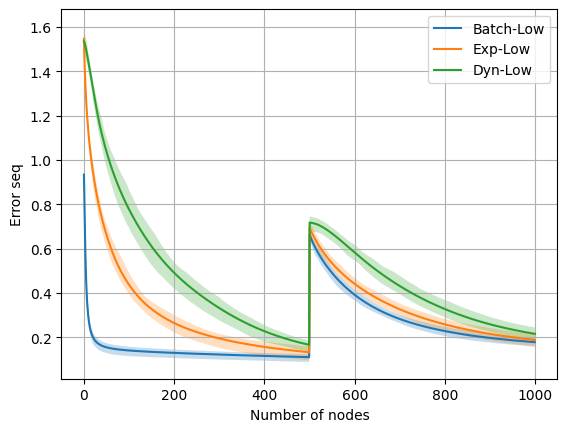

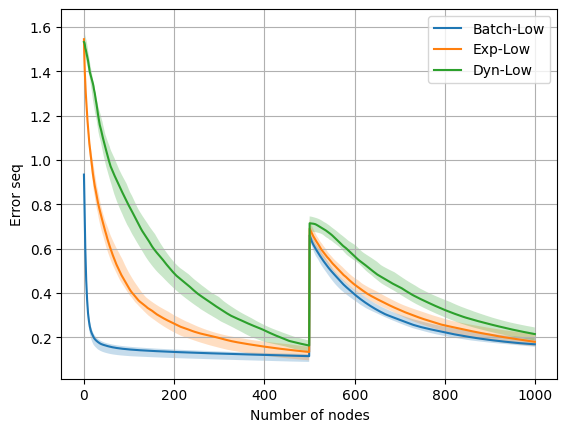

In [4]:
graph_p['new_nodes'] = [30]
signal_p['samples_t'] = 500

Exps = [
    # Offline as a baseline!
    # {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'leg': 'Off-Low', 'fmt': '-',
    #  'args': {'iters_sample': 50, 'cold_start': False}},

    # Online and batch
    {'model': models.Offline_dyn_nti, 'args': {'iters_sample': 1,}, 'leg': 'Batch-Low', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'leg': 'Exp-Low', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'leg': 'Dyn-Low', 'fmt': '-'},
]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_experiment)(g, Exps, graph_p, signal_p, default_args, verb) for g in range(n_graphs))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

err_seq_low, runtime_low = zip(*results)

fig, axes = plt.subplots()
utils.plot_data(axes, err_seq_low, Exps, np.arange(err_seq_low[0].shape[0]), 'Number of nodes', 'Error seq',
                    agg='mean', deviation='prctile')
fig, axes = plt.subplots()
utils.plot_data(axes, err_seq_low, Exps, np.arange(err_seq_low[0].shape[0]), 'Number of nodes', 'Error seq',
                    agg='median', deviation='prctile')

## High frequency

CPUs employed: 64
- 1. Batch-Low: Err 1st graph: 0.124   -   Err last graph: 0.243   -   time: 0.913 secs
- 1. Exp-Low: Err 1st graph: 0.142   -   Err last graph: 0.272   -   time: 0.981 secs
- 1. Dyn-Low: Err 1st graph: 0.098   -   Err last graph: 0.233   -   time: 0.896 secs
----- Solved in 0.053 minutes -----


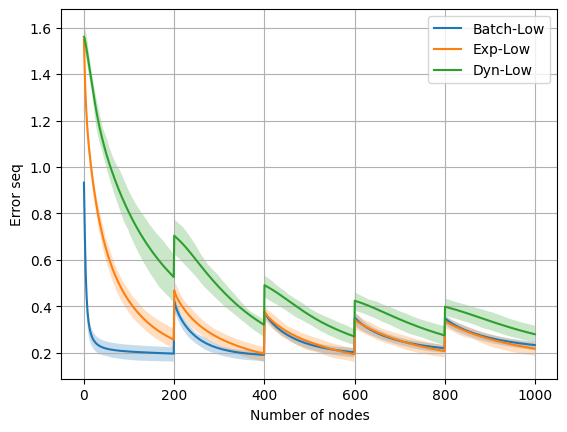

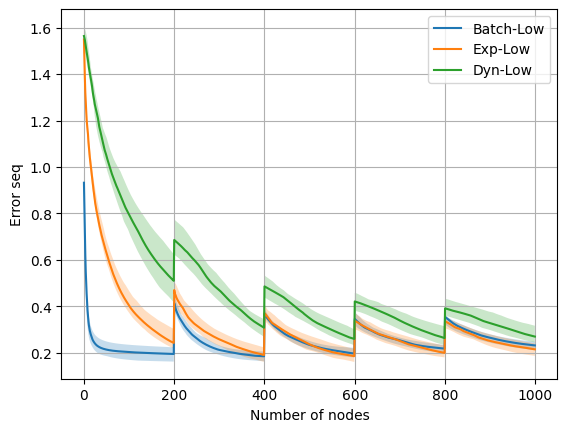

In [5]:
graph_p['new_nodes'] = [8]*4
signal_p['samples_t'] = 200

Exps = [
    # Offline as a baseline!
    # {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'leg': 'Off-Low', 'fmt': '-',
    #  'args': {'iters_sample': 50, 'cold_start': False}},
     
    {'model': models.Offline_dyn_nti, 'args': {'iters_sample': 1,}, 'leg': 'Batch-Low', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'leg': 'Exp-Low', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'leg': 'Dyn-Low', 'fmt': '-'},
]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_experiment)(g, Exps, graph_p, signal_p, default_args, verb) for g in range(n_graphs))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

err_seq_high, runtime_high = zip(*results)

fig, axes = plt.subplots()
utils.plot_data(axes, err_seq_high, Exps, np.arange(err_seq_high[0].shape[0]), 'Number of nodes', 'Error seq',
                    agg='mean', deviation='prctile')
fig, axes = plt.subplots()
utils.plot_data(axes, err_seq_high, Exps, np.arange(err_seq_high[0].shape[0]), 'Number of nodes', 'Error seq',
                    agg='median', deviation='prctile')

# Frequency incoming nodes

In [6]:
signal_p_aux = signal_p.copy()
signal_p_aux = {
    'samples_t': [100] + [1000]*5,
    'noise_power': .05,
}

Exps = [
    # {'model': models.Offline_dyn_nti, 'args': {'iters_sample': 10,}, 'leg': 'offline', 'fmt': '-'},
    # {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'graph_p': {'new_nodes': [1]*50},
    #  'sig_p': {'samples_t': 100}, 'leg': '1 every 100', 'fmt': '-'},
    
    # {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'graph_p': {'new_nodes': [2]*25},
    #  'sig_p': {'samples_t': [100] + [200]*25}, 'leg': '2 every 200', 'fmt': '-'},

    
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'graph_p': {'new_nodes': [5]*10},
     'sig_p': {'samples_t': [100] + [500]*10}, 'leg': '5 every 500, d', 'fmt': '-'},

    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'graph_p': {'new_nodes': [10]*5},
     'sig_p': {'samples_t': [100] + [1000]*5}, 'leg': '10 every 1000, d', 'fmt': '-'},
    
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'graph_p': {'new_nodes': [50]},
     'sig_p': {'samples_t': [2550] + [2550]}, 'leg': '50 every 5000, d', 'fmt': '-'},

    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'graph_p': {'new_nodes': [50]},
     'sig_p': {'samples_t': [100] + [5000]}, 'leg': '50 every 5000, d', 'fmt': '-'},

    
    
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'graph_p': {'new_nodes': [5]*10},
     'sig_p': {'samples_t': [100] + [500]*10}, 'leg': '5 every 500', 'fmt': '-'},

    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'graph_p': {'new_nodes': [10]*5},
     'sig_p': {'samples_t': [100] + [1000]*5}, 'leg': '10 every 1000', 'fmt': '-'},
    
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'graph_p': {'new_nodes': [50]},
     'sig_p': {'samples_t': [2550] + [2550]}, 'leg': '50 every 5000', 'fmt': '-'},

    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'graph_p': {'new_nodes': [50]},
     'sig_p': {'samples_t': [100] + [5000]}, 'leg': '50 every 5000', 'fmt': '-'},
]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_experiment)(g, Exps, graph_p, signal_p_aux, default_args, verb) \
                                  for g in range(n_graphs))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

err_seq, runtime = zip(*results)

fig, axes = plt.subplots()
utils.plot_data(axes, err_seq, Exps, np.arange(err_seq[0].shape[0]), 'Number of nodes', 'Error seq',
                    agg='mean', deviation='prctile')
fig, axes = plt.subplots()
utils.plot_data(axes, err_seq, Exps, np.arange(err_seq[0].shape[0]), 'Number of nodes', 'Error seq',
                    agg='median', deviation='prctile')



CPUs employed: 64


TypeError: run_experiment() takes from 5 to 6 positional arguments but 7 were given